In [27]:
# !pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# from scikeras.wrappers import KerasClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



## Import Data

In [4]:
data = pd.read_csv('./cleaned_hatecrime.csv', index_col=0)
data.head(2)

,RecordId,ClosedYear,MonthOccurrence,County,NCIC,TotalNumberOfVictims,TotalNumberOfIndividualVictims,SuspectsRaceAsAGroup,TotalNumberOfSuspects,MostSeriousUcr,MostSeriousUcrType,MostSeriousLocation,MostSeriousBias,MostSeriousBiasType,MostSeriousVictimType,WeaponType,Offensive_Act,label
5411,CA00-0000015217,2004,2,Alameda,Alameda Co. Sheriff's Department,2,2,Unknown,0,Intimidation,Violent Crimes,Residence/Home/Driveway,Anti-Black or African American,Race/Ethnicity/Ancestry,Person,None,Daubing of swastika,4.0
5412,CA00-0000015122,2004,3,Alameda,Alameda,1,1,White,1,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Asian,Race/Ethnicity/Ancestry,Person,None,Threatening letters/flyers/email,4.0


## Transform and Scale Data

### Column Transformer

In [5]:
X = data.drop(columns=['RecordId', 'label'])
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)
X_encoded = ct.fit_transform(X)
X_encoded
ct.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded, columns=ct.get_feature_names_out())

X_encoded.head(2)

,County_Alameda,County_Alpine,County_Amador,County_Butte,County_Calaveras,County_Colusa,County_Contra Costa,County_Del Norte,County_El Dorado,County_Fresno,...,Offensive_Act_Other,Offensive_Act_Rock throwing,Offensive_Act_Threatening letters/flyers/email,Offensive_Act_Unknown,Offensive_Act_Verbal slurs,ClosedYear,MonthOccurrence,TotalNumberOfVictims,TotalNumberOfIndividualVictims,TotalNumberOfSuspects
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2004.0,2.0,2.0,2.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2004.0,3.0,1.0,1.0,1.0


### Scaling

In [6]:
X_encoded_scaled = StandardScaler().fit_transform(X_encoded)

## Target

In [7]:
y = data['label']

y.unique()

y_mapped = y.map(
    {'4.0': 4,
     '2.0': 2,
     '0.0': 0,
     '1.0': 1, 
     '3.0': 3,
     'None': 5}
)

y_categorical = to_categorical(y_mapped, 6)

## Baseline

In [8]:
y_mapped.value_counts(normalize=True)

4    0.521314
2    0.338187
0    0.095769
5    0.038265
1    0.005204
3    0.001261
Name: label, dtype: float64

## Test/Train Split


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y_categorical, stratify=y, random_state=13)

X_train.shape

y_train.shape

(14268, 6)

## Random Forest

In [10]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7361782636115198

### Confusion Matrix Display

In [15]:
y_preds = rf.predict(X_test)

''

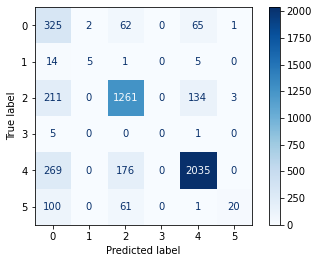

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), np.rint(y_preds).argmax(axis=1), cmap='Blues')
;

### Balanced Accuracy Score

In [20]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.4380761557437864

## Extra Trees

In [22]:
et = ExtraTreesClassifier(n_jobs=-1)
et.fit(X_train, y_train)
et.score(X_test, y_test)

0.6909817111624974

### Confusion Matrix Display

In [23]:
y_preds = et.predict(X_test)

''

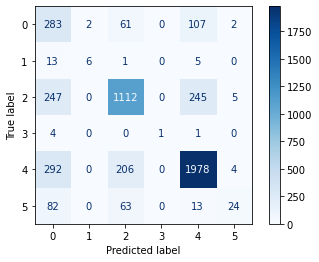

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), np.rint(y_preds).argmax(axis=1), cmap='Blues')
;

### Balanced Accuracy Score

In [25]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.44153432631755174

## RandomizedSearchCV on Extra Trees

### Extra Trees

In [33]:
et = ExtraTreesClassifier()

In [34]:
et.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [35]:
params = {
    'n_estimators': range(100, 1000)
}

### RandomizedSearchCV

In [36]:
rs = RandomizedSearchCV(
    et,
    params,
    n_jobs=-1
)

rs_result = rs.fit(X_train, y_train)

# Result summary
print(f"Best score: {rs_result.best_score_}. Used these parameters: {rs_result.best_params_}")

# This part copied from machine learning mastery prints out all results to check where improvements can be made
means = rs_result.cv_results_['mean_test_score']
stds = rs_result.cv_results_['std_test_score']
params = rs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best score: 0.7000284434855207. Used these parameters: {'n_estimators': 478}
0.693580 (0.009005) with: {'n_estimators': 481}
0.695823 (0.007956) with: {'n_estimators': 482}
0.697785 (0.008356) with: {'n_estimators': 688}
0.697996 (0.008286) with: {'n_estimators': 439}
0.696594 (0.008220) with: {'n_estimators': 594}
0.700028 (0.006137) with: {'n_estimators': 374}
0.700028 (0.011324) with: {'n_estimators': 478}
0.699187 (0.009727) with: {'n_estimators': 610}
0.698487 (0.009793) with: {'n_estimators': 844}
0.697785 (0.006862) with: {'n_estimators': 962}


In [38]:
y_preds = rs_result.best_estimator_.predict(X_test)

In [41]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.40312381705485517